In [1]:
import numpy as np
import pandas as pd


from tqdm import tqdm

/Users/seantrott/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.8' currently installed).
  warnings.warn(msg, UserWarning)


In [29]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # makes figs nicer!

## Read in data

In [2]:
df_np = pd.read_csv("data/processed/full_nps.csv")
len(df_np)

4701

In [3]:
df_np.head(5)

,Unnamed: 0,ppt_id,head_noun,card,pair_type,trial_result,head_noun_tag,dep,AoA,Conc.M,Dom_Pos,Lg10WF
0,1,83,hands,Nozzle,Friend,Out of time,NNS,dobj,9.32,4.91,Noun,1.3010
1,2,83,occupation,Job,Friend,Won,NN,ROOT,5.39,3.19,Noun,4.3235
2,3,83,ocean,Sushi,Friend,Won,NN,pobj,11.19,4.96,Noun,2.3483
3,4,83,table,Pizza,Friend,Won,NN,pobj,4.67,5.00,Noun,3.2330
4,5,83,predator,Owl,Friend,Lost,NN,nsubj,6.21,4.93,Noun,2.4579


In [4]:
df_np['success'] = df_np['trial_result'] == "Won"
df_np['success'].mean()

0.5624335247819613

In [5]:
len(df_np)

4701

## Get word embeddings

In [6]:
GLOVE_PATH = "data/lexical_statistics/glove.6B.300d.txt"

In [7]:
def compile_glove_dict(path = GLOVE_PATH):
	embeddings_dict = {}
	pbar = tqdm(total = 400000)
	with open(GLOVE_PATH, 'r', encoding="utf-8") as f:
	    for line in f:
	        values = line.split()
	        word = values[0]
	        vector = np.asarray(values[1:], "float32")
	        embeddings_dict[word] = vector

	        pbar.update(1)

	return embeddings_dict

In [8]:
gd = compile_glove_dict()

100%|█████████▉| 399472/400000 [00:39<00:00, 10926.58it/s]

## Get Lancaster norms

In [9]:
df_lancaster = pd.read_csv("data/lexical_statistics/lancaster_norms.csv")
df_lancaster['word'] = df_lancaster['Word'].str.lower()

In [10]:
LS_COLUMNS = ['Auditory.mean', 'Gustatory.mean', 'Haptic.mean',
		   'Interoceptive.mean', 'Olfactory.mean', 'Visual.mean', 'Foot_leg.mean',
       'Hand_arm.mean', 'Head.mean', 'Mouth.mean', 'Torso.mean']

In [11]:
sm_norms = dict(zip(df_lancaster['word'].values, df_lancaster[LS_COLUMNS].values))

## Filter dataframe

In [12]:
glove_words = gd.keys()

In [13]:
df_np['target'] = df_np['card'].str.lower()
len(df_np)

4701

In [14]:
df_np_reduced = df_np[df_np['target'].isin(glove_words)]
len(df_np_reduced)

4701

100%|██████████| 400000/400000 [00:50<00:00, 10926.58it/s]

In [15]:
df_np_reduced = df_np[df_np['target'].isin(sm_norms.keys())]
len(df_np_reduced)

4695

In [16]:
df_np_reduced = df_np_reduced[df_np_reduced['head_noun'].isin(glove_words)]
len(df_np_reduced)

4671

In [17]:
df_np_reduced = df_np_reduced[df_np_reduced['head_noun'].isin(sm_norms.keys())]
len(df_np_reduced)

4168

## Get embeddings for targets

In [18]:
target_words = np.array(list(set(df_np_reduced['target'].values)))

In [19]:
X_target_gd = []
for w in target_words:
    X_target_gd.append(gd[w])
X_target_gd = np.array(X_target_gd)

In [20]:
X_target_sm = []
for w in target_words:
    X_target_sm.append(sm_norms[w])
X_target_sm = np.array(X_target_sm)

In [21]:
len(target_words)

415

In [22]:
len(X_target_gd)

415

In [23]:
len(X_target_sm)

415

## Embed hints

In [24]:
hints = df_np_reduced['head_noun'].values

In [25]:
X_hint_gd = []
for w in hints:
    X_hint_gd.append(gd[w])
X_hint_gd = np.array(X_hint_gd)

In [26]:
X_hint_sm = []
for w in hints:
    X_hint_sm.append(sm_norms[w])
X_hint_sm = np.array(X_hint_sm)

In [27]:
len(X_hint_gd)

4168

In [28]:
len(X_hint_sm)

4168

## Guessing game

In [30]:
from scipy.spatial.distance import cdist, cosine

In [33]:
correct_answer = df_np_reduced['target'].values
len(correct_answer)

4168

In [34]:
success = df_np_reduced['success'].values

In [35]:
K = [1, 5, 20, 40, 60, 80, 100]

In [37]:
performance = []
for k in K:
    print("Trying {k}-nearest neighbors.".format(k = k))
    for index, _ in enumerate(X_hint_gd):
        
        ## Actually correct answer
        correct_response = correct_answer[index]
        
        #### First, get Glove performance
        vector_gd = X_hint_gd[index]
        D_gd = np.array([i[0] for i in cdist(X_target_gd, [vector_gd], metric = "cosine")])
        smallest_k_indices_gd = np.argpartition(D_gd, k)
        # Get guesses
        k_guesses_gd = target_words[smallest_k_indices_gd[:k]]
        # Correct?
        correct_gd = correct_response in k_guesses_gd
        
        #### Next, get Lancaster performance
        vector_sm = X_hint_sm[index]
        D_sm = np.array([i[0] for i in cdist(X_target_sm, [vector_sm], metric = "cosine")])
        smallest_k_indices_sm = np.argpartition(D_sm, k)
        # Get guesses
        k_guesses_sm = target_words[smallest_k_indices_sm[:k]]
        # Correct?
        correct_sm = correct_response in k_guesses_sm
        

        performance.append({
            'hint': hints[index],
            'target': correct_response,
            'correct': correct_gd,
            'Model': 'Glove',
            # 'correct_sm': correct_sm,
            'k': k,
            'success': success[index]
        })

        performance.append({
            'hint': hints[index],
            'target': correct_response,
            'correct': correct_sm,
            'Model': 'Lancaster',
            # 'correct_sm': correct_sm,
            'k': k,
            'success': success[index]
        })
        
        performance.append({
            'hint': hints[index],
            'target': correct_response,
            'correct': k/len(target_words),
            'Model': 'Random',
            # 'correct_sm': correct_sm,
            'k': k,
            'success': success[index]
        })
        

Trying 1-nearest neighbors.
Trying 5-nearest neighbors.
Trying 20-nearest neighbors.
Trying 40-nearest neighbors.
Trying 60-nearest neighbors.
Trying 80-nearest neighbors.
Trying 100-nearest neighbors.


In [38]:
df_perf = pd.DataFrame(performance)
len(df_perf)

87528

In [39]:
df_perf.head(5)

,hint,target,correct,Model,k,success
0,occupation,job,False,Glove,1,True
1,occupation,job,True,Lancaster,1,True
2,occupation,job,0.00241,Random,1,True
3,ocean,sushi,False,Glove,1,True
4,ocean,sushi,False,Lancaster,1,True


In [40]:
df_perf['success'].mean()

0.5609404990403071

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

In [42]:
random_chance = [k/len(target_words) for k in K]

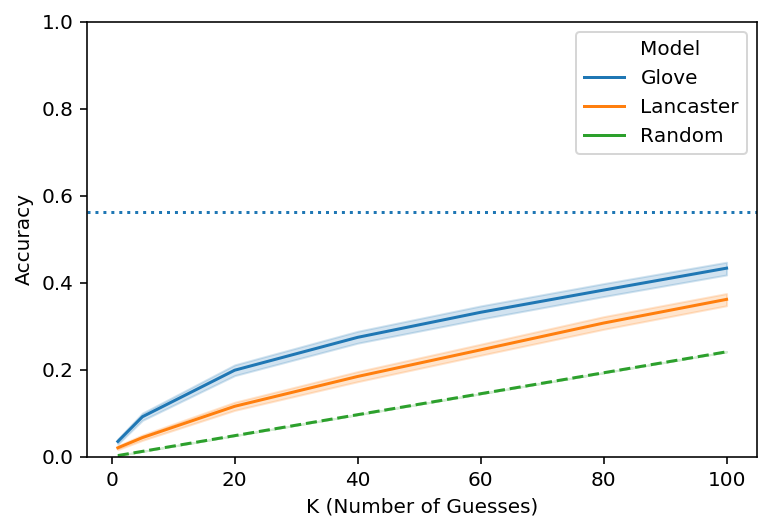

In [44]:
ax = sns.lineplot(data = df_perf,
               x = 'k',
               y = 'correct',
                hue = 'Model')

plt.ylabel("Accuracy")
plt.xlabel("K (Number of Guesses)")

ax.lines[2].set_linestyle("dashed")

plt.axhline(y = df_np['success'].mean(), linestyle = "dotted")
plt.ylim(0, 1)

plt.savefig("Figures/guessing/perf.png", dpi = 300)